<a href="https://colab.research.google.com/github/rylan-berry/DataScienceExercises2025-2026/blob/main/RylaBerrU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🐧Penguin Bill Length Predtiction🐧

##Installs and Imports

In [1]:
!pip install bambi
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
import graphviz as gv
import seaborn as sns
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 5.1 MB/s eta 0:00:00


##Context
The very start of biology was because of analysing finch bills (beaks). So, why not look at another species of bird, penguins, and try to figure out what factors go into their bill length.


##Previous Assumptions and Data Collection
The data was  collected from my teacher's collection of datasets for our class. Some data cleaning  was needed  to get rid of NaN values and some preprocessing for the pair plot.

In [2]:
#Data from teacher
penguin_data = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv')

In [3]:
penguin_data.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007


In [4]:
pen_data = penguin_data.dropna()

In [5]:
#generated by gemini for the perposes of using a seaborn pair plot on the categorical data.
pen_data_processed = pen_data.copy()

pen_data_processed['species'] = pen_data_processed['species'].astype('category').cat.codes
pen_data_processed['island'] = pen_data_processed['island'].astype('category').cat.codes
pen_data_processed['sex'] = pen_data_processed['sex'].astype('category').cat.codes

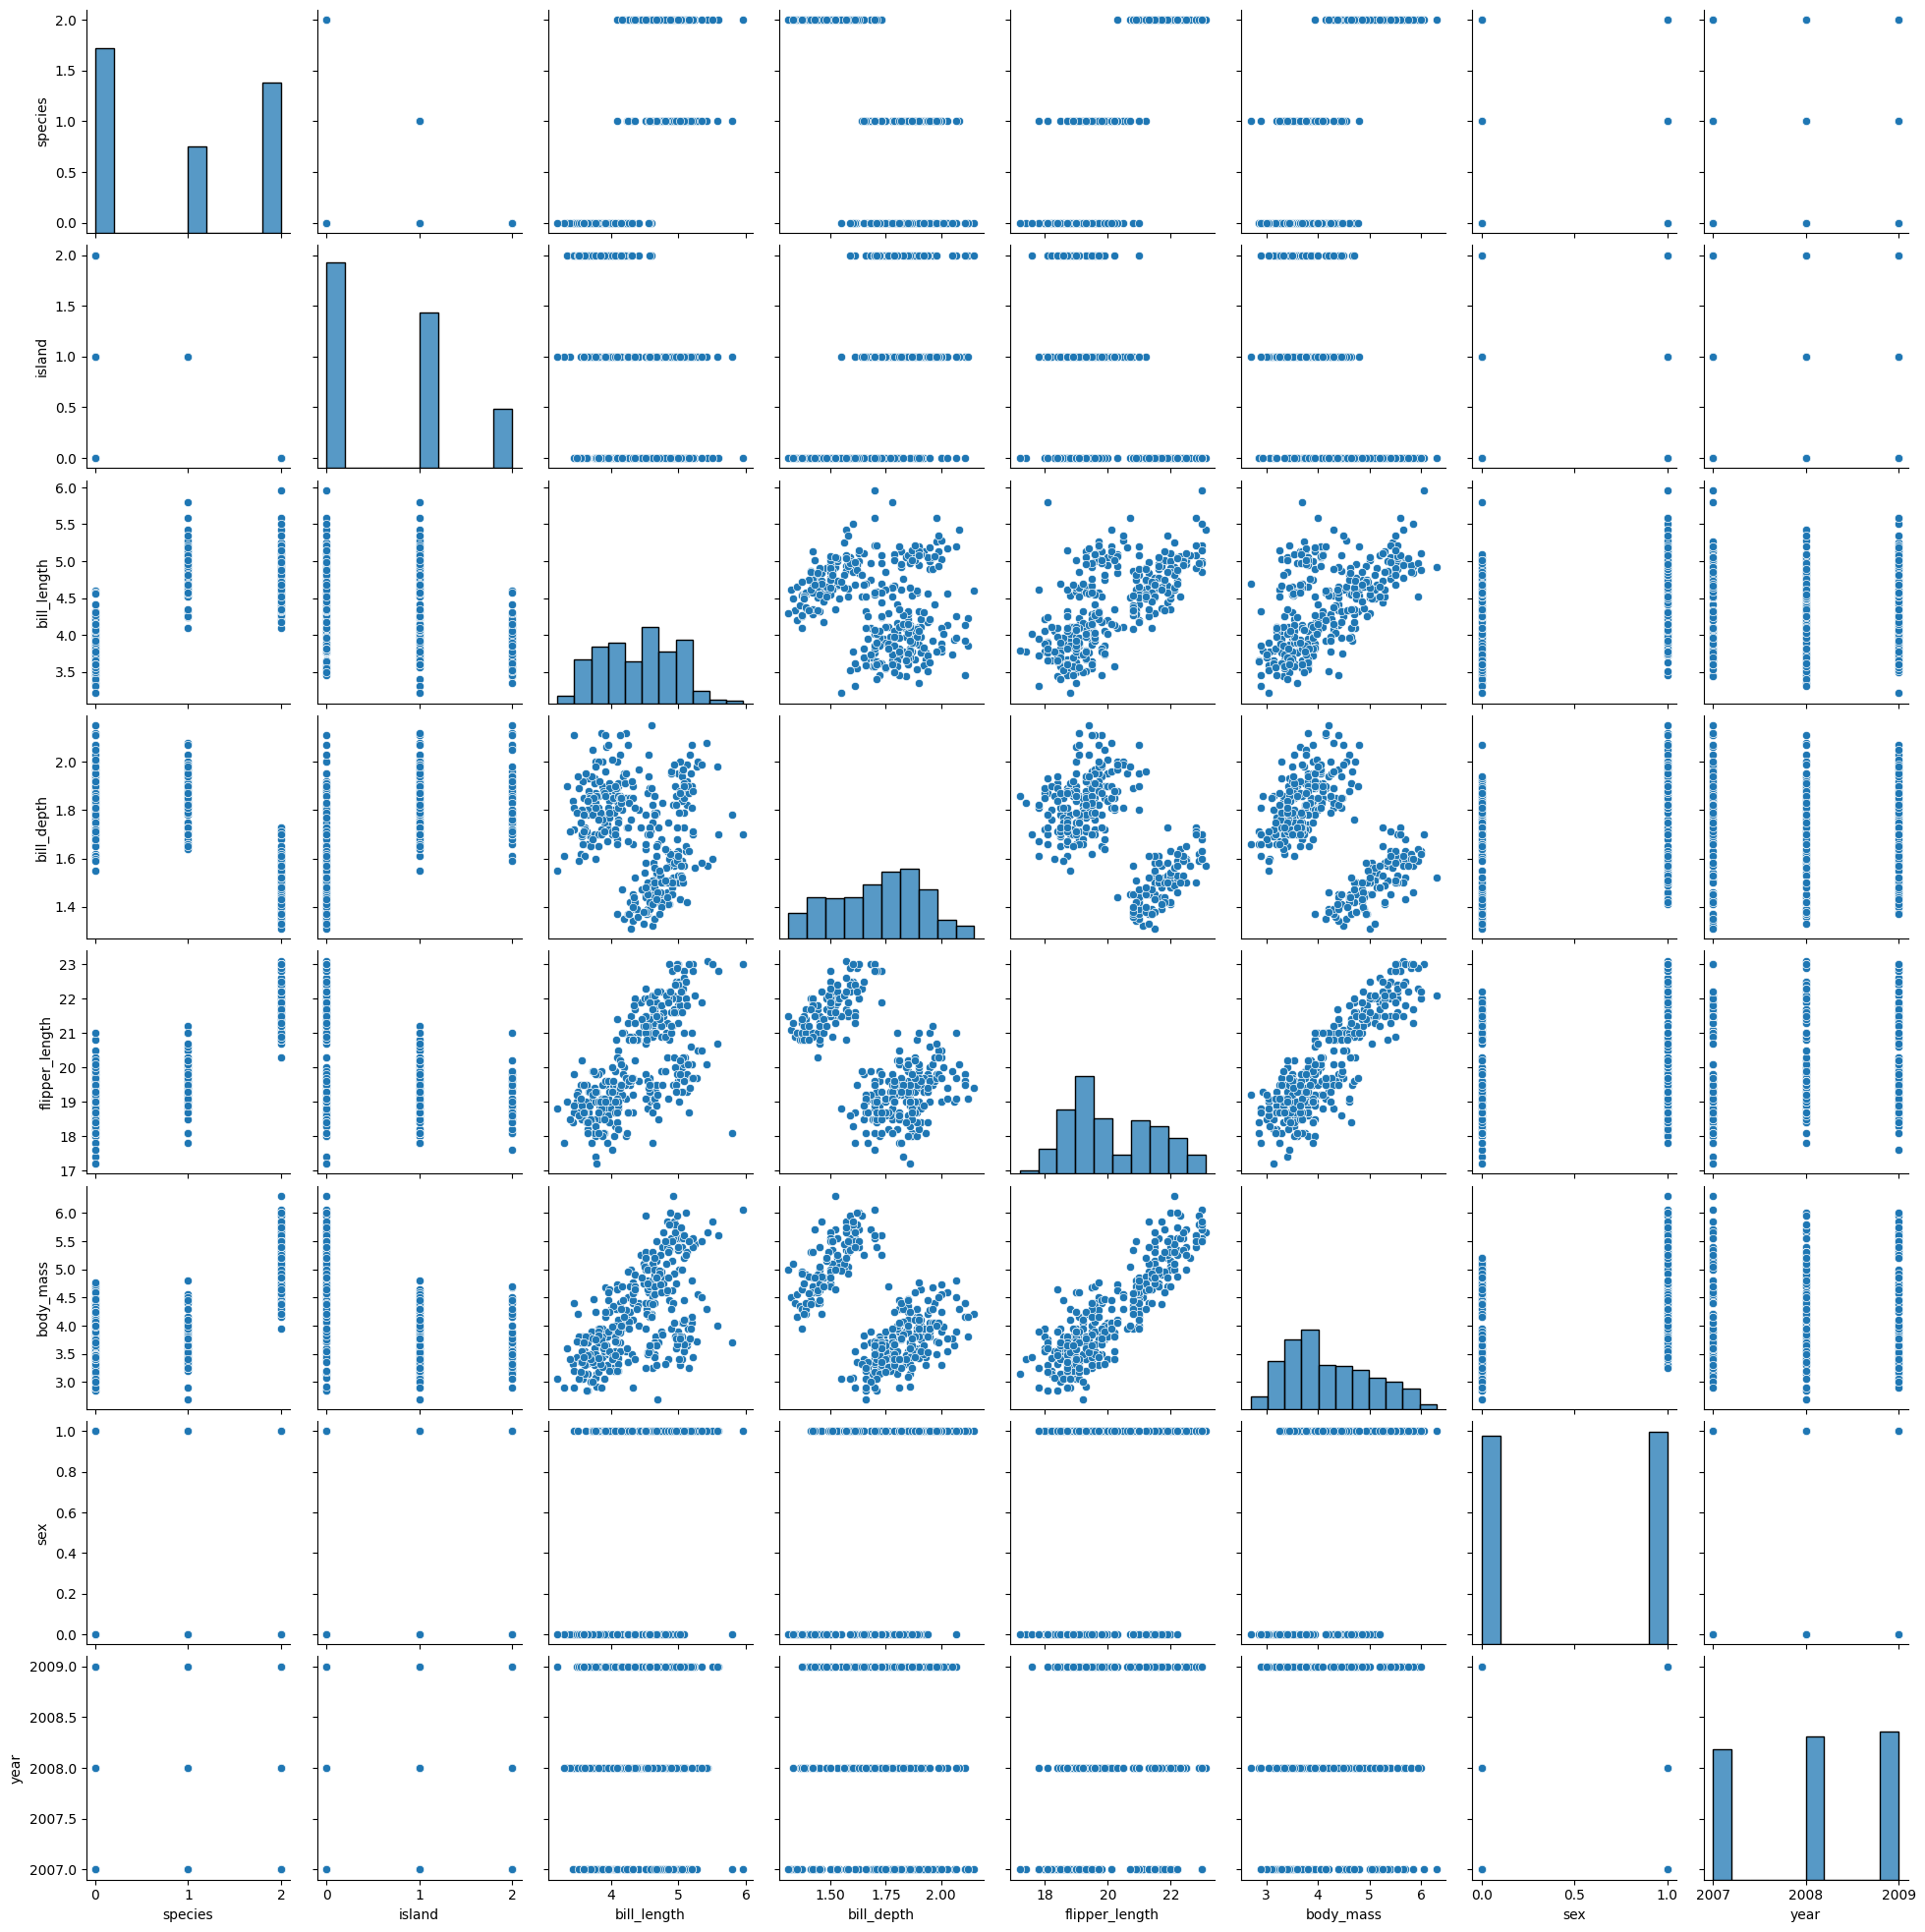

In [6]:
sns.pairplot(pen_data_processed)

This pair plot shows come correlation between bill length and the following: speicies, island, bill depth, body mass, flipper length, and gender.

The following is my causal diagram of the complete situation, specifically how it relates to bill length.

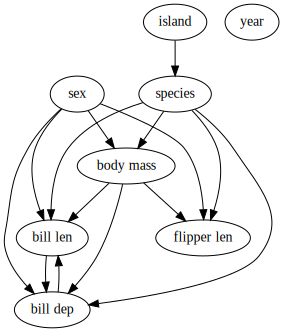

In [7]:
p_dag = gv.Digraph(name="Penguins DAG")

p_dag.node('L','bill len')
p_dag.node('Y','year')
p_dag.node('D','bill dep')
p_dag.node('F','flipper len')
p_dag.node('M','body mass')
p_dag.node('S','species')
p_dag.node('G','sex')
p_dag.node('I','island')

p_dag.edges(['LD', 'DL', 'ML', 'MD','MF',  'SL', 'SD','SF', 'SM', 'IS', 'GL', 'GD','GF', 'GM'])

p_dag

I think year is for the most part unrelated to any of the data, I also decided that the Island should have a more indirect role since A. too many categoricals mess up the model, and B. environment is more likely to effect how species evolve and the traits they gain. I do think that the penguin's gender will have an effect on the overall biology of the animals,  and I also think that the flippers don't have any direct effects on the bill. I do think the size of the penguins (i.e. body mass) will effect their bills. Lastly, I think there can be some relation between bill length aand bill depth, but I don't think it's very useful since a penguin can have thick but short bills, or long but thin bills.

##Likelyhood and Priors

With all that was previously discussed, I think a model with only species, body mass, and sex will preform quite well. However, I think that bill depth, year, island, and flipper length won't contribute nearly as much. Also, based on the distribution of bill length, I think a Normal/Gaussian likelyhood would work best.

##Species, Body (mass), and  Sex Model (SBS Model)

In [ ]:
model_sbs = bmb.Model("bill_length ~ species +  sex + body_mass + sex:body_mass + species:body_mass", pen_data)
idata_sbs = model_sbs.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

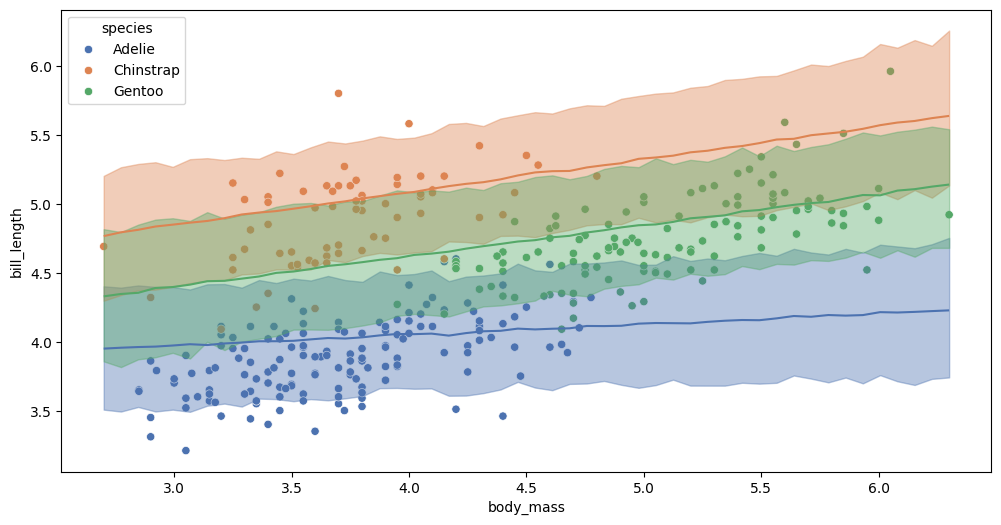

In [9]:
#Color matching by Gemini
# Get unique species and define a consistent order
unique_species = sorted(pen_data['species'].unique())

# Define a color palette using seaborn
palette = sns.color_palette("deep", n_colors=len(unique_species))

# Set matplotlib's default color cycle to match the seaborn palette
# This will affect the colors used by bambi's plot_predictions
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)

_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))

bmb.interpret.plot_predictions(model_sbs,
                               idata_sbs,
                               ["body_mass","species"], ax=ax, pps=True)

sns.scatterplot(data=pen_data,
                x="body_mass",
                y="bill_length",
                hue="species",
                hue_order=unique_species, # Ensure seaborn uses the same order as the cycler
                palette=palette, # Explicitly use the defined palette
                ax=ax,
                zorder=-3)

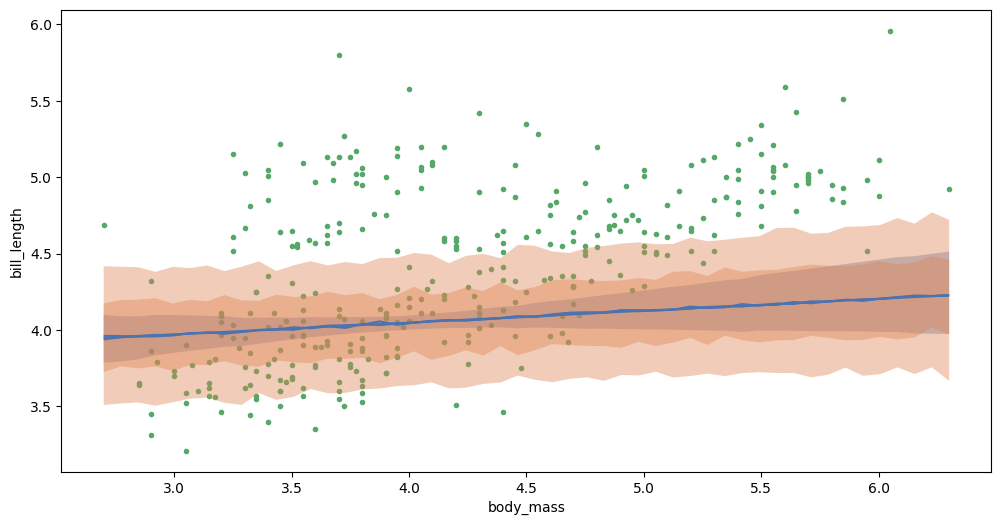

In [10]:

#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_sbs, idata_sbs, "body_mass", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_sbs, idata_sbs, "body_mass", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_sbs, idata_sbs, "body_mass", pps=True,  ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(pen_data.body_mass, pen_data.bill_length, "C2.", zorder=-3)


##Bill Depth Model (With many interactions)

In [ ]:
model_bill_dep = bmb.Model("bill_length ~ sex + species + body_mass + bill_depth + sex:body_mass + species:body_mass + bill_depth:body_mass + bill_depth:species + bill_depth:sex", pen_data)
idata_bill_dep = model_bill_dep.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

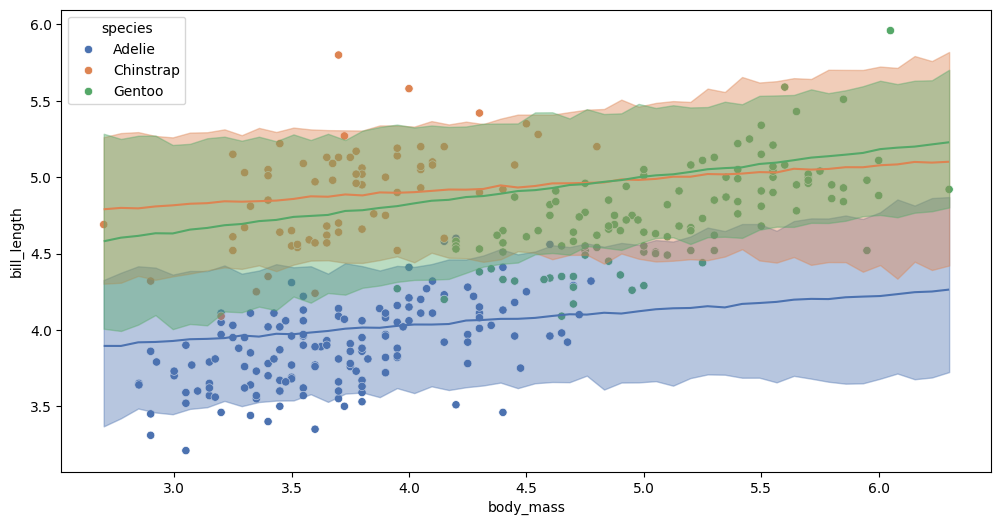

In [12]:
# Get unique species and define a consistent order
unique_species = sorted(pen_data['species'].unique())

# Define a color palette using seaborn
palette = sns.color_palette("deep", n_colors=len(unique_species))

_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_bill_dep,
                               idata_bill_dep,
                               ["body_mass","species"], ax=ax, pps=True)

sns.scatterplot(data=pen_data,
                x="body_mass",
                y="bill_length",
                hue="species",
                hue_order=unique_species,
                palette=palette,
                ax=ax,
                zorder=-3)

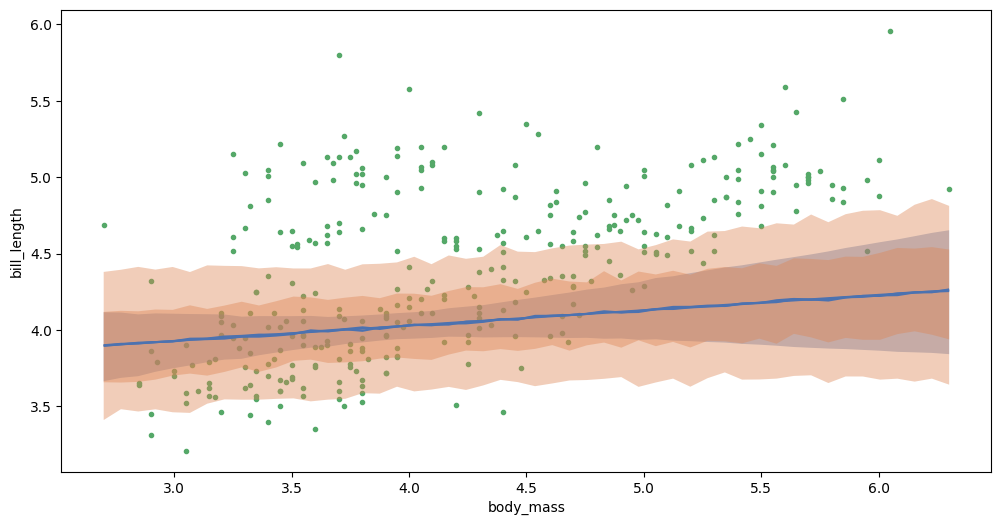

In [13]:

#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_bill_dep, idata_bill_dep, "body_mass", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_bill_dep, idata_bill_dep, "body_mass", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_bill_dep, idata_bill_dep, "body_mass", pps=True,  ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(pen_data.body_mass, pen_data.bill_length, "C2.", zorder=-3)


##Species and Body Mass Only Model (SB Model)

In [ ]:
model_sb = bmb.Model("bill_length ~ species + body_mass + species:body_mass", pen_data)
idata_sb = model_sb.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

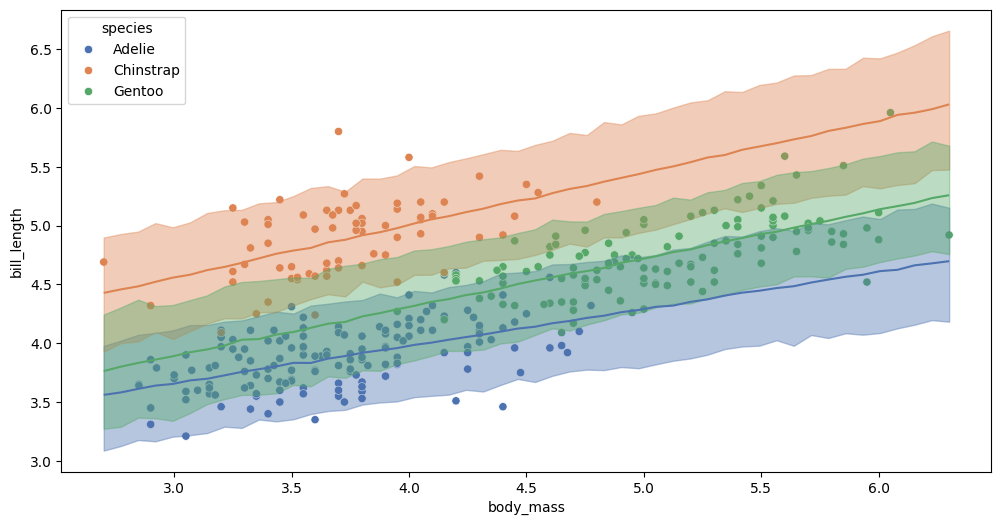

In [15]:
# Get unique species and define a consistent order
unique_species = sorted(pen_data['species'].unique())

# Define a color palette using seaborn
palette = sns.color_palette("deep", n_colors=len(unique_species))

_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_sb,
                               idata_sb,
                               ["body_mass","species"], ax=ax, pps=True)

sns.scatterplot(data=pen_data,
                x="body_mass",
                y="bill_length",
                hue="species",
                hue_order=unique_species,
                palette=palette,
                ax=ax,
                zorder=-3)

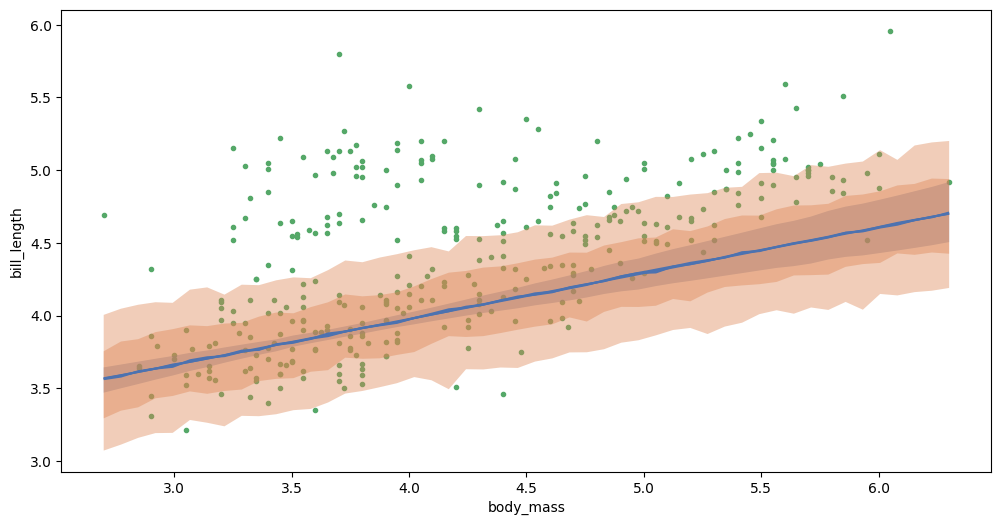

In [16]:

#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_sb, idata_sb, "body_mass", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_sb, idata_sb, "body_mass", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_sb, idata_sb, "body_mass", pps=True,  ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(pen_data.body_mass, pen_data.bill_length, "C2.", zorder=-3)


##SBS and Bill Depth & Flipper Length Model (BDFL Model)

In [ ]:
model_bdfl = bmb.Model("bill_length ~ sex + species + body_mass + bill_depth + sex:body_mass + species:body_mass + bill_depth:body_mass + bill_depth:species + bill_depth:sex + flipper_length:body_mass + flipper_length:species + flipper_length:sex", pen_data)
idata_bdfl = model_bdfl.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

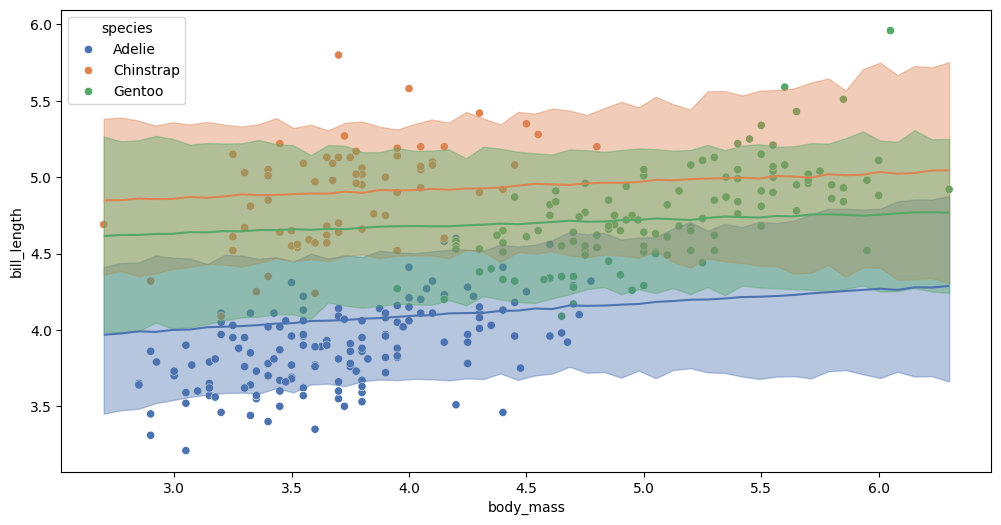

In [18]:
# Get unique species and define a consistent order
unique_species = sorted(pen_data['species'].unique())

# Define a color palette using seaborn
palette = sns.color_palette("deep", n_colors=len(unique_species))

_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_bdfl,
                               idata_bdfl,
                               ["body_mass","species"], ax=ax, pps=True)

sns.scatterplot(data=pen_data,
                x="body_mass",
                y="bill_length",
                hue="species",
                hue_order=unique_species,
                palette=palette,
                ax=ax,
                zorder=-3)

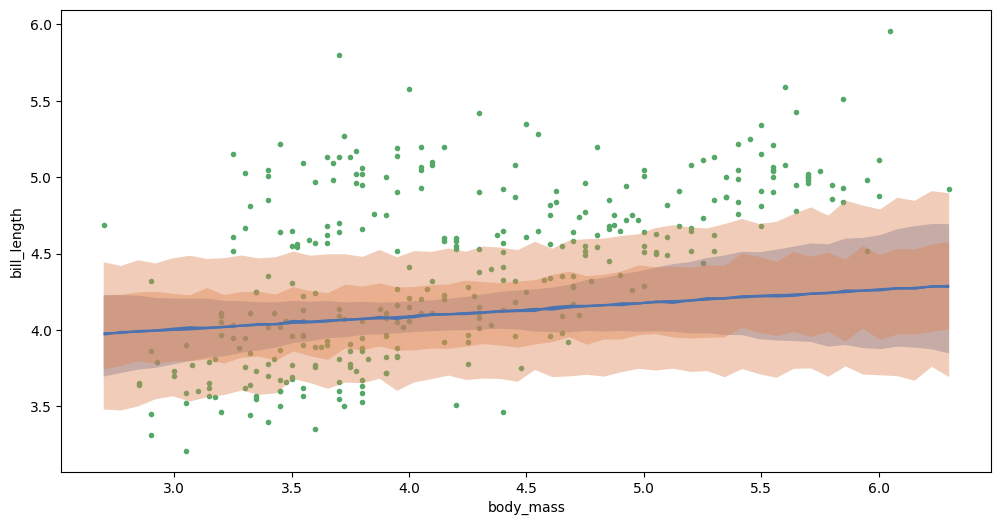

In [19]:

#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_bdfl, idata_bdfl, "body_mass", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_bdfl, idata_bdfl, "body_mass", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_bdfl, idata_bdfl, "body_mass", pps=True,  ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(pen_data.body_mass, pen_data.bill_length, "C2.", zorder=-3)


##Body Mass Model (BM Model)

In [ ]:
model_bm = bmb.Model("bill_length ~ body_mass", pen_data)
idata_bm = model_bm.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

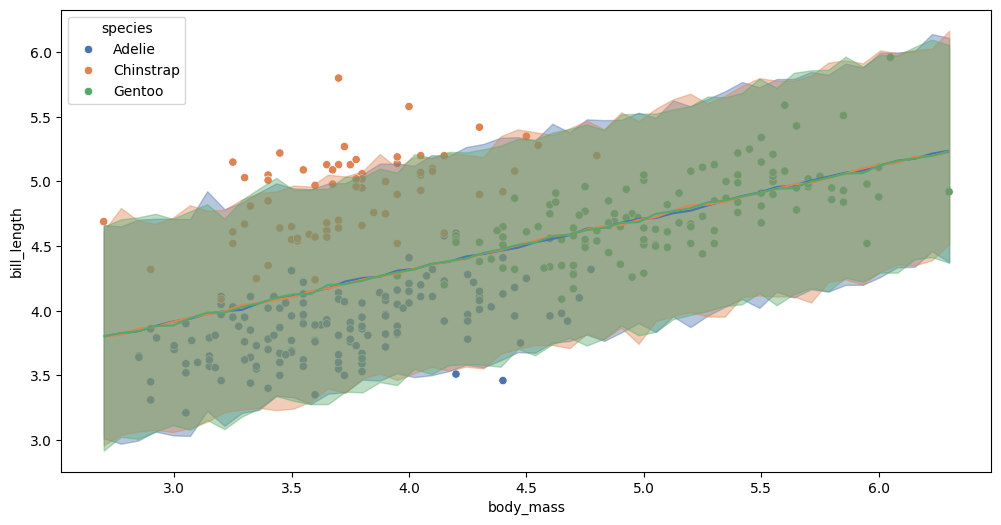

In [21]:
# Get unique species and define a consistent order
unique_species = sorted(pen_data['species'].unique())

# Define a color palette using seaborn
palette = sns.color_palette("deep", n_colors=len(unique_species))

_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_bm,
                               idata_bm,
                               ["body_mass","species"], ax=ax, pps=True)

sns.scatterplot(data=pen_data,
                x="body_mass",
                y="bill_length",
                hue="species",
                hue_order=unique_species,
                palette=palette,
                ax=ax,
                zorder=-3)

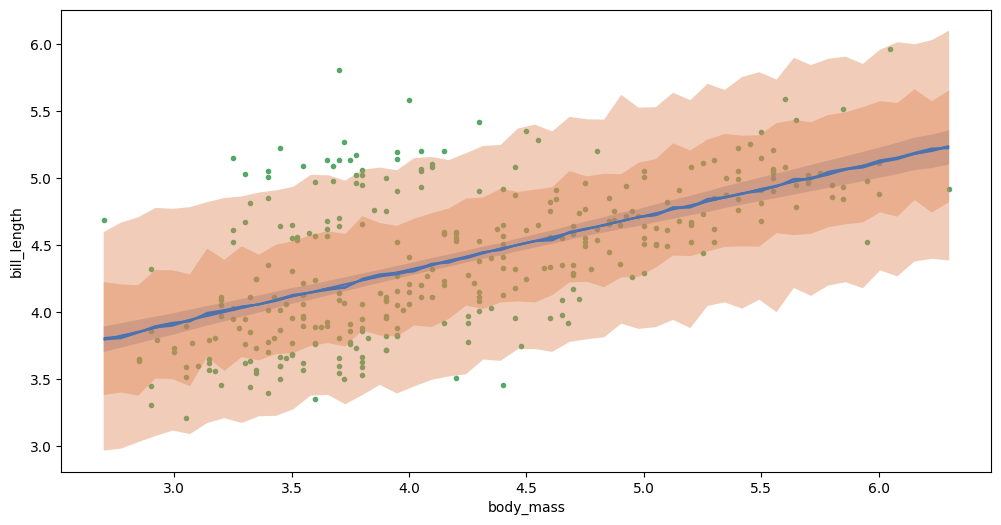

In [22]:

#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_bm, idata_bm, "body_mass", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_bm, idata_bm, "body_mass", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_bm, idata_bm, "body_mass", pps=True,  ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(pen_data.body_mass, pen_data.bill_length, "C2.", zorder=-3)


##Body and Sex Model (BS Model)

In [ ]:
model_bs = bmb.Model("bill_length ~ body_mass + sex + sex:body_mass", pen_data)
idata_bs = model_bs.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

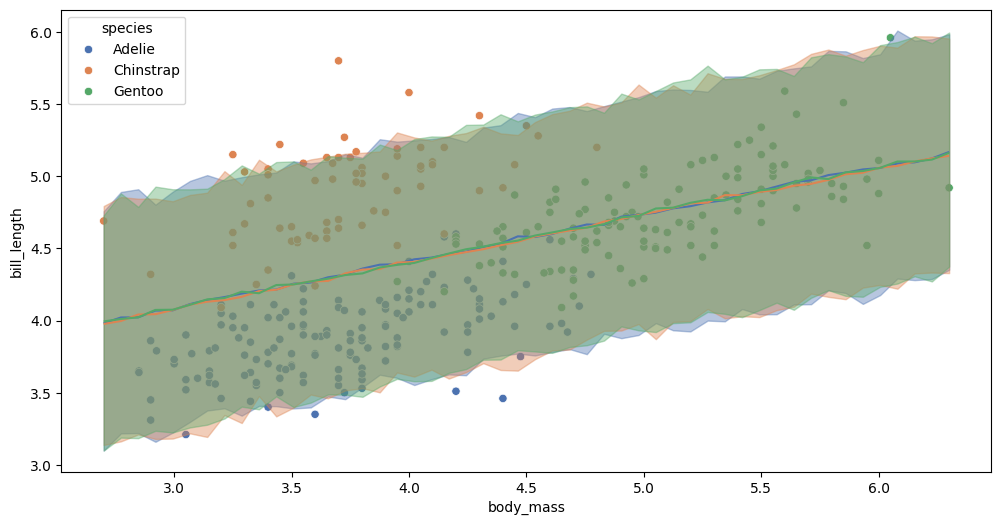

In [24]:
# Get unique species and define a consistent order
unique_species = sorted(pen_data['species'].unique())

# Define a color palette using seaborn
palette = sns.color_palette("deep", n_colors=len(unique_species))

_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_bs,
                               idata_bs,
                               ["body_mass","species"], ax=ax, pps=True)

sns.scatterplot(data=pen_data,
                x="body_mass",
                y="bill_length",
                hue="species",
                hue_order=unique_species,
                palette=palette,
                ax=ax,
                zorder=-3)

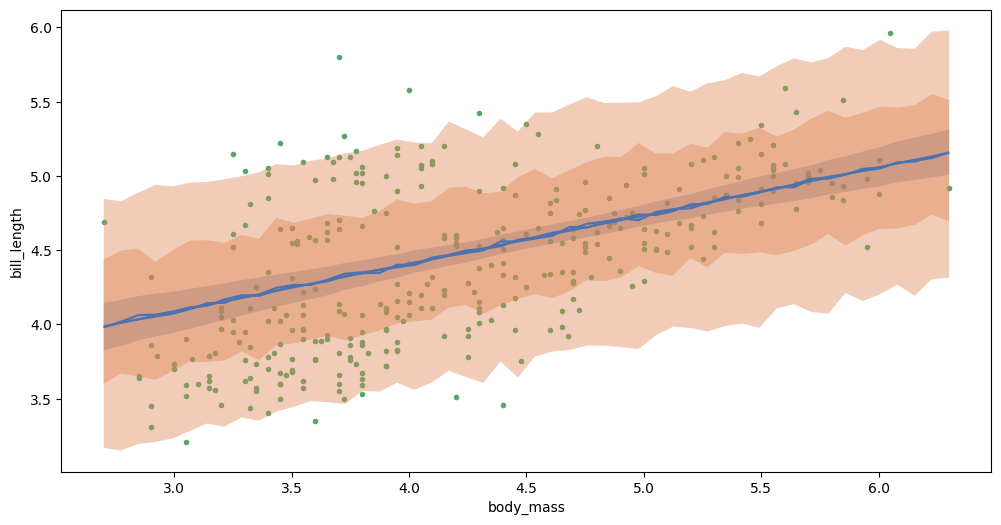

In [25]:

#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_bs, idata_bs, "body_mass", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_bs, idata_bs, "body_mass", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_bs, idata_bs, "body_mass", pps=True,  ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(pen_data.body_mass, pen_data.bill_length, "C2.", zorder=-3)


##Species Model

In [ ]:
model_spec = bmb.Model("bill_length ~ species", pen_data)
idata_spec = model_spec.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

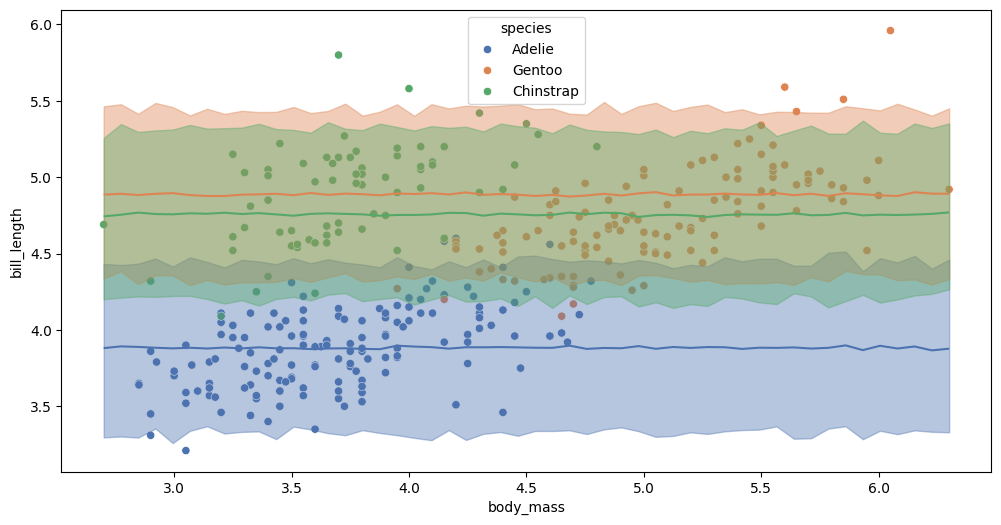

In [27]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_spec,
                               idata_spec,
                               ["body_mass","species"], ax=ax, pps=True)
sns.scatterplot(data=pen_data, x="body_mass", y="bill_length", hue="species", ax=ax, zorder=-3)

##Conclusion (Part 1)
Most of the models seem to marginally predict bill length pretty well. But especially between the less feature models and higher feature models there are verying model standards. Some of the body mass only models predict the data on a closer slope, but across the models that start to include species, they seem to move further from a general slope of the data to trying to make a slope of the individual species. But how  well does this change make the preformance?

##Epld_loo Compares and their Conclusions

In [28]:
cmp = az.compare({
    'SBS':idata_sbs, 'SBS + depth':idata_bill_dep, 'Species + body mass':idata_sb, 'SBS + BDFL':idata_bdfl, "Body Mass":idata_bm, "Body + Sex":idata_bs, "Species":idata_spec
    })
cmp

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
SBS + BDFL,0,22.922640,19.716080,0.000000,8.462534e-01,19.535245,0.000000,True,log
SBS + depth,1,21.944476,14.409602,0.978164,1.167830e-01,18.316799,3.491577,False,log
SBS,2,18.589294,9.639402,4.333346,5.684834e-11,17.786262,5.378307,False,log
Species + body mass,3,-3.293166,7.219415,26.215806,1.102985e-11,14.569431,10.243281,False,log
Species,4,-71.245153,4.498152,94.167794,3.696357e-02,14.620956,14.892356,False,log
Body + Sex,5,-200.664463,4.380045,223.587103,2.348174e-11,13.189736,16.692488,False,log
Body Mass,6,-202.778969,2.716729,225.701609,3.753287e-11,13.601875,17.966859,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

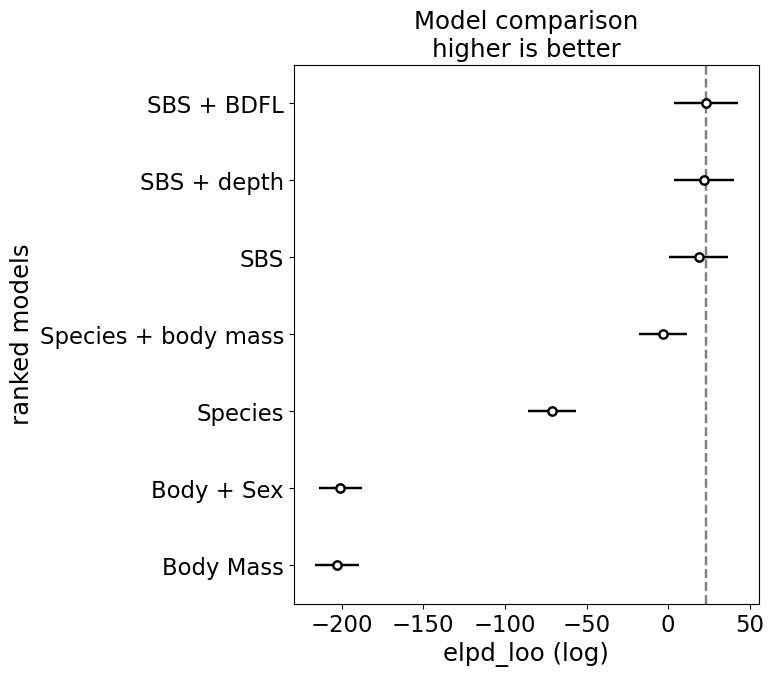

In [29]:
az.plot_compare(cmp)

###Conclusion (Part 2)
Evidently, the models without species (Body Mass, and  Body & Sex Models) preform far below that of the species models (Species, Species & Body Mass, Species Body & Sex, SBS & Bill Depth, and SBS & Bill Depth & Flipper Length Models), with even the only species model preforming higher than the non-species model. The fact species has such a great impact on the model tells us that it's very important to the bill length. Another noticable feature is the inclusion of body mass to a species model creates a large bump in preformance, indicating it's another important feature.

In [30]:
cmp = az.compare({
    'Species + body + sex (SBS)':idata_sbs, 'SBS + depth':idata_bill_dep, 'Species + body mass':idata_sb, 'BDFL Model':idata_bdfl
    })
cmp

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
BDFL Model,0,22.922640,19.716080,0.000000,8.345218e-01,19.535245,0.000000,True,log
SBS + depth,1,21.944476,14.409602,0.978164,7.007984e-02,18.316799,3.491577,False,log
Species + body + sex (SBS),2,18.589294,9.639402,4.333346,1.404963e-16,17.786262,5.378307,False,log
Species + body mass,3,-3.293166,7.219415,26.215806,9.539835e-02,14.569431,10.243281,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

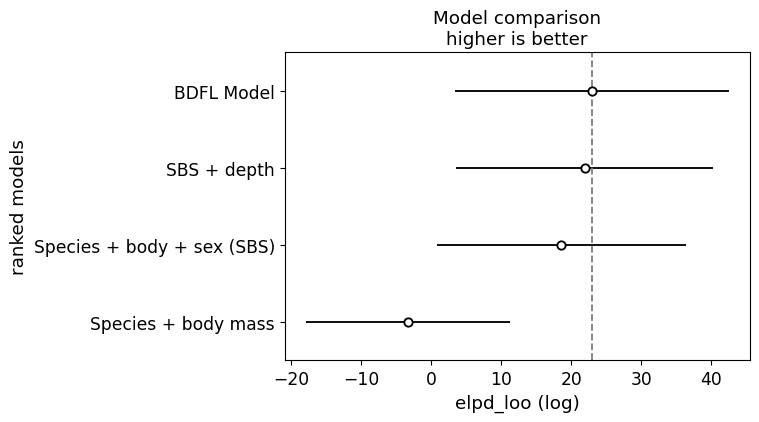

In [31]:
az.plot_compare(cmp)

###Conclusion (Part 3)
And comparing the top models reveals more information, the inclusions of bill depth and flipper length don't improve the model that much, only preforming marginally better than the species, body, and sex only model. This indicates that bill depth, and flipper length even more so, contribute very little to the prediction. Another detail of this graph is sex, when comparing the species, body, and sex model to the species and body model, they aren't too far from eachother, indicating that the penguin's sex isn't as important as other features. However, the accuracy increase is still quite noticable, indicating that the sex of the penguins does have some impact on bill length.

##Species Island Model (SPIS Model) & It's comparison.

In [ ]:
model_spis = bmb.Model("bill_length ~ species + island", pen_data)
idata_spis = model_spis.fit(idata_kwargs={"log_likelihood":True})

<Axes: xlabel='body_mass', ylabel='bill_length'>

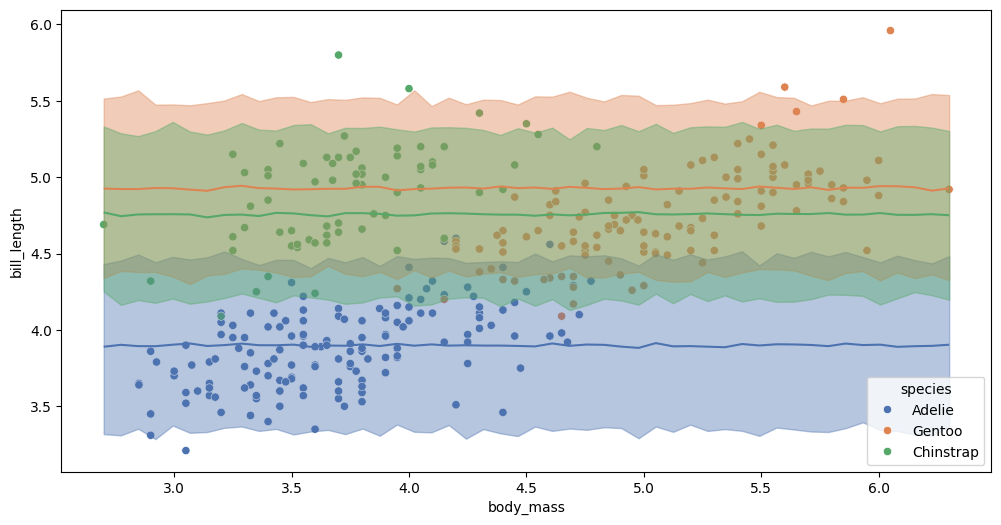

In [33]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_spis,
                               idata_spis,
                               ["body_mass","species"], ax=ax, pps=True)
sns.scatterplot(data=pen_data, x="body_mass", y="bill_length", hue="species", ax=ax, zorder=-3)

In [34]:
cmp = az.compare({
    'SBS':idata_sbs, "Species":idata_spec, "Species + Island":idata_spis
    })
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
SBS,0,18.589294,9.639402,0.000000,0.972673,17.786262,0.000000,False,log
Species,1,-71.245153,4.498152,89.834447,0.027327,14.620956,11.877524,False,log
Species + Island,2,-72.516085,5.986452,91.105379,0.000000,14.498839,11.822557,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

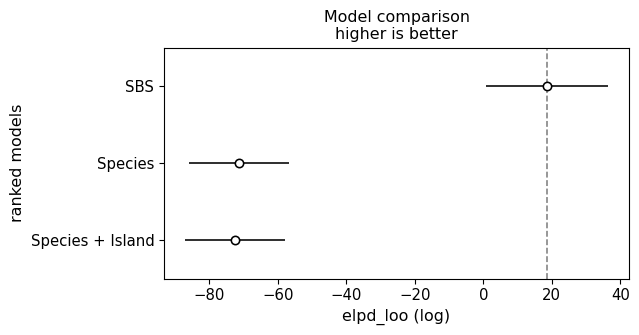

In [35]:
az.plot_compare(cmp)

###Conclusion (Part 4)
This graph shows that a species model and species & island model have the same preformance. Which supports the earlier idea that island isn't important to predicting bill lenght. And, if it has any impact at all, is mostly tied to speices.

##Conclusion and Take Aways (Part 5)
With all that has been discussed, species seems to be the most important factor in the bill length of a penguin, which makes sense because it's one of those features that changes via evolution and genetics. The second best feature would be body mass, which again is logical since most speices, size of body parts is usually proportional to other parts instead of them being constant sizes throughout a species. And the third best is sex, which again makes sense since many species have variation as a result of gender, like many other species of birds where males are more colorful than females. These top factors indicate beak lenght as being a result of the penguins biology from birth.